In [2]:
from navipy.forecasting.predictor_box import Modelmaker
import numpy as np
from navipy.forecasting.predictor_box import Investigator
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from navipy.trajectories import Trajectory
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In this tutorial we want to predict the trajectory of a bee based on its previous trajectory.
For this purpose we will use the ARIMA model. ARIMA models are especially suitable for time series data because it caters to a suite of standard sturctures in those. 
Basically a linear regression model is cotnructed and the data is prepared by a dregree of differencing in order to make it stationary. i.e remove trends and seasonal sturctures that negatively effect the regression model.

first we load our data. In our case we have a frame with 6 columns, that descrip the position of the bee at the relative time given by the index.
the x,y and z location as well as the bee's orientation as yaw, pitch and roll was recorded.
To load the data we use navipy's trajectory module.

In [3]:
from navipy.trajectories import Trajectory
fname = '/media/luiza/Daten/Repos/tmpnavibox/body_traj/bee_05_head_traj.hdf'
df = pd.read_hdf(fname)

traj=Trajectory()
out=traj.from_dataframe(df)
print(traj.head())

  location             zyx                
         x   y   z alpha_0 alpha_1 alpha_2
0      NaN NaN NaN     NaN     NaN     NaN
1      NaN NaN NaN     NaN     NaN     NaN
2      NaN NaN NaN     NaN     NaN     NaN
3      NaN NaN NaN     NaN     NaN     NaN
4      NaN NaN NaN     NaN     NaN     NaN


next we need to check rather our data is stationary and hence suitable for ARIMA. For that purpose we can use navipy's forecasting module. But first we need to remove all nan and infs from the data.
We do that with the consecutive_blocks() methods of navipy's trajectory module, which will provide us with the blocks of the trajectory that did not contain andy nans.
Then we use the investigator to see which dimensions of the trajectory (x,y,z,yaw (alpha_0), pitch(alpha_1), roll(alpha_3)) are stationary.
in the result below you can see that only roll is stationary for all blocks.


In [4]:
from navipy.forecasting.predictor_box import Investigator

blocks = traj.consecutive_blocks()

Inv_ar = Investigator(blocks)
statdf = Inv_ar.check_stationary()
statdf.index.name = 'trial#'
statdf.head()

location                   zyx                
              x      y      z alpha_0 alpha_1 alpha_2
trial#                                               
0         False  False  False   False    True    True
1         False  False  False   False    True    True
2         False  False  False   False   False    True
3         False   True  False   False    True    True

But we still want to predict the trajectory, so we need to transform the data to make it stationary.
So will just use the velocity (or differenciation) of the trajectory data.
We can easily calculate it by calling the velocity() function on the trajectory.

In [ ]:
velocity_blocks=[]
for b in blocks:
    if len(b)<=2000:
        continue
    vels=b.velocity()
    #the next line only works with my version of navipy
    vels[['dalpha_0','dalpha_1','dalpha_2']]=b.angle_velocity()
    velocity_blocks.append(vels.dropna())


now we will check again for the stationarity on the velocity. Note that we also removed blocks that were to small to provide enough training data. So we kept only the once that had at least 2000 observations.

In [6]:
Inv_ar = Investigator(velocity_blocks)
statdf = Inv_ar.check_stationary()
statdf.index.name = 'trial#'
statdf.head()

dx    dy    dz dalpha_0 dalpha_1 dalpha_2
trial#                                             
0       True  True  True     True     True     True

now we need to find the right parameters for the arima model. It takes three parameters, p,d,and q.
- p is the number of lag observations
- d is the order of differenciation
- q the size of the average window

To get an idea for a good value of p, we can use the autocorrelation graph
This graph shows us the correlation depending on p. In the example below, 40 is the last value at which we can still observe a correlation, therefore a p of 40 is suggested here. But be aware but this is just a suggestion and micht not be an optimal choice.

   dx  dy  dz dalpha_0 dalpha_1 dalpha_2
0  40  40  36        1        1        1


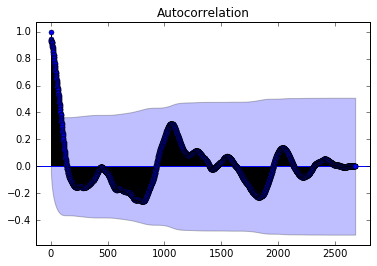

In [7]:
sig_lags = Inv_ar.get_significant_lags()
Inv_ar.plot_cf_function(trial_id=0, dim=['dx'], function_type='acf')
print(sig_lags)

now we will use navipy's modelmaker to create a arima model, and split the data into training and testing data. each block is treated individually. When training a arima model, we need to specify several parameters:

- trial_id : which blocks to be used (0 is for all)
- pred_step : forecasting window
- p : arimas p parameter
- d : arimas d parameter
- n_preds : number of predictions to be predited
- dim : dimensions to be used (data table columns)

Here we want to predict the trajectory for the x coordinate. First we do it with a value of 15 for p, because the data is not stationary with a p value of 40

In [ ]:
Mom_ar1 = Modelmaker(velocity_blocks)
Mom_ar1.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar1.apply_arima_models(trial_id=[0], pred_step=1, p=15,d=2,n_preds=130, dim='dx')


Now we will plot to results for visualization. The blue curve shows the predition and the green one what we actually want to achieve. Note that we have to shift the estimate by 3.
<font color=red> - Why do I have to shift here? The shift seams to depend on the value for p. The bigger p the bigger the shift. But this is not consistent for all examples.
And also the estimate a bit to small. Or there is a scaling factor (see other examples, for more clarity on the scaling factor)</font>

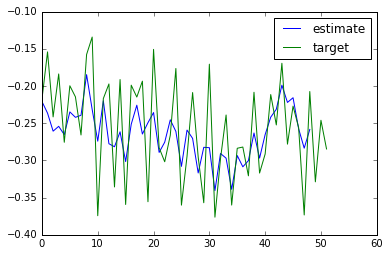

In [22]:
Results = Mom_ar1.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[78:127],label='estimate')
#plt.figure()
plt.plot(y[75:127],label='target')
plt.legend()

Now we will try to use a p of 20

In [12]:
Mom_ar5 = Modelmaker(velocity_blocks)
Mom_ar5.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar5.apply_arima_models(trial_id=[0], pred_step=5, p=20,d=1,n_preds=200, dim='dx')

KeyboardInterrupt: 

<font color=red>Here I have a scaling problem aka estimate and target dont have the same amplitude, this is probably related to the pred_step size. (see other examples) But In this case I have the problem that I am not centered around 0, so I can not multiply one of them, because that will also lead to an offset. And I am not sure how to center around zero since the graph is changing in its average.</font>

In [ ]:
Results = Mom_ar5.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
avg_hat=np.average(y_hat)
avg=np.average(y)

plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(y[75:125],label='target')
plt.legend(loc='upper left')

Now we will predict the yaw with a lag/p of 1 for 2000 steps. 

In [15]:
Mom_ar2 = Modelmaker(velocity_blocks)
Mom_ar2.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar2.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=2,n_preds=2000, dim='dalpha_2')


and again visualize the result. As you can see, here the result is a better than before.

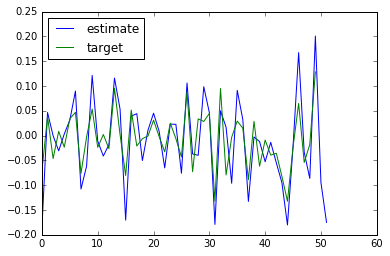

In [25]:
Results = Mom_ar2.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(y[75:125],label='target')
plt.legend(loc='upper left')

Now we will try to use a bigger predition window. before we used only one time step, now we will use 30

In [42]:
Mom_ar3 = Modelmaker(velocity_blocks)
Mom_ar3.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar3.apply_arima_models(trial_id=[0], pred_step=30, p=1,d=2,n_preds=2000, dim='dalpha_2')


As one can see, does the predition become worse and we have some scaling factor in the estimate. Note that we have to scale the real value with a value of 30 aka scale the estimate by 0.3.
<font color=red>Why do I have to scale here? The scale seams to depend on the prediction step. The scaling factor equals the value of pred_step</font>

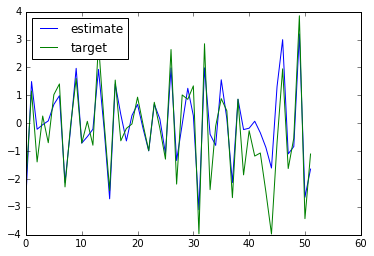

In [46]:
Results = Mom_ar3.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(np.array(y[75:127])*30,label='target')
plt.legend(loc='upper left')

Now I will use a d of 1, so the trajectory data is differenciated only once. Now the estimate does not overshoot so much as before. But now the amplitude is a bit too low sometimes. And the fit is not as good as with d=2

In [67]:
Mom_ar6 = Modelmaker(velocity_blocks)
Mom_ar6.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar6.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=1,n_preds=2000, dim='dalpha_2')


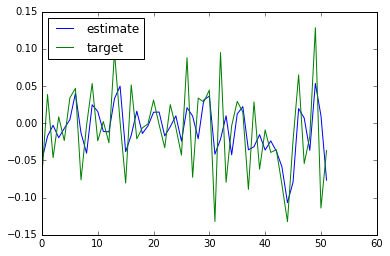

In [72]:
Results = Mom_ar6.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(np.array(y[75:127]),label='target')
plt.legend(loc='upper left')

Now I will compare the estimations for the yaw velocity when using d=1 and pred_step=30
<font color=red> It looks like the scaling factor is not as high when using d=1. Why? Bu thte shift is constant</font>

In [103]:
Mom_ar7 = Modelmaker(velocity_blocks)
Mom_ar7.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar7.apply_arima_models(trial_id=[0], pred_step=30, p=1,d=1,n_preds=2000, dim='dalpha_2')


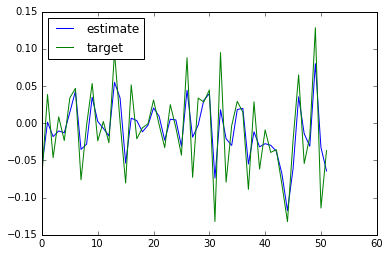

In [107]:
Results = Mom_ar7.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(np.array(y[75:127]),label='target')
plt.legend(loc='upper left')

Now lets add some error terms. First we will add only on, by setting q to 1

In [6]:
Mom_ar8 = Modelmaker(velocity_blocks)
Mom_ar8.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar8.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=1,q=1,n_preds=2000, dim='dalpha_2')


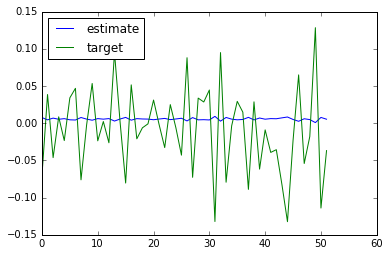

In [11]:
Results = Mom_ar8.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(y_hat[76:128],label='estimate')
#plt.figure()
plt.plot(np.array(y[75:127]),label='target')
plt.legend(loc='upper left')

apparently wasn't the error term a good choice.
Lets check for dx

In [9]:
Mom_ar9 = Modelmaker(velocity_blocks)
Mom_ar9.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar9.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=1,q=1,n_preds=200, dim='dx')


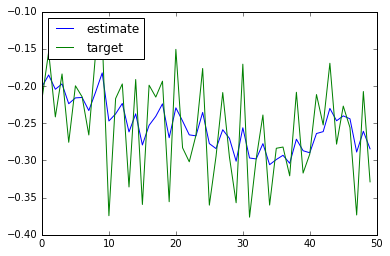

In [16]:
Results = Mom_ar9.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(np.array(y_hat[77:127]),label='estimate')
#plt.figure()
plt.plot(np.array(y[75:125]),label='target')
plt.legend(loc='upper left')

In this case, it seams like an error term would be okay, as the shape is still similar, but the amplitute of the estimate is much lower than the actual amplitute. 

In [8]:
Mom_ar10 = Modelmaker(velocity_blocks)
Mom_ar10.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar10.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=1,n_preds=200, dim='dx')


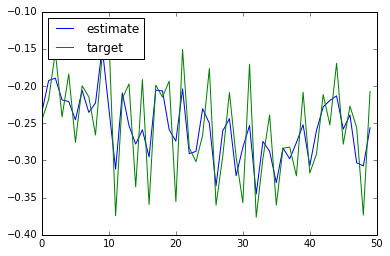

In [11]:
Results = Mom_ar10.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(np.array(y_hat[77:127]),label='estimate')
#plt.figure()
plt.plot(np.array(y[75:125]),label='target')
plt.legend(loc='upper left')

| dim/Parameter | pred_step |   p   |   d   |   q   | scaling problem          | shift problem | comment |
|---------------|-----------|-------|-------|-------|--------------------------|---------------|---------|
| 'dx'          |     1     |   1   |   1   |   0   | estimate a bit too small | shift=2       |         |
| 'dx'          |     1     |   1   |   1   |   1   | estimate way too small   | shift=2     |  shape not so good |
| 'dx'          |     1     |   15  |   2   |   0   | estimate too small       | shift=3       |         |
| 'dalpha_2'    |     1     |   1   |   2   |   0   | estimate a bit too big   | shift=1       |         |
| 'dalpha_2'    |     30    |   1   |   2   |   0   | scaling is okay          | shift=1       |         |
| 'dalpha_2'    |     1    |   10   |   2   |   0   | estimate is too small    | 3       |     shape is not so good    |
| 'dalpha_2'    |     1     |   1   |   1   |   0   | estimate too small       | shift=1       |         |
| 'dalpha_2'    |     30    |   1   |   1   |   0   | estimate is too small    | shift=1       |         |
| 'dalpha_2'    |     1     |   1   |   1   |   1   | estimate is super much too small | shift=1 |  looks very wrong|
| 'dalpha_2'    |     1    |   1   |   0   |   0   | estimate is too small    | ?       |     very bad    |

It seams like the shift goes up with bigger p, and the scaling is influenced by many factors

In [ ]:
Mom_ar11 = Modelmaker(velocity_blocks)
Mom_ar11.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar10.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=1,q=2,n_preds=200, dim='dx')


In [ ]:
Results = Mom_ar11.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(np.array(y_hat[77:127]),label='estimate')
#plt.figure()
plt.plot(np.array(y[75:125]),label='target')
plt.legend(loc='upper left')

In [13]:
Mom_ar12 = Modelmaker(velocity_blocks)
Mom_ar12.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar12.apply_arima_models(trial_id=[0], pred_step=1, p=1,d=0,q=0,n_preds=2000, dim='dalpha_2')


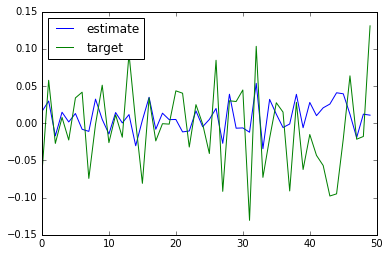

In [24]:
Results = Mom_ar12.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(np.array(y_hat[75:125]),label='estimate')
#plt.figure()
plt.plot(np.array(y[75:125]),label='target')
plt.legend(loc='upper left')

In [26]:
Mom_ar13 = Modelmaker(velocity_blocks)
Mom_ar13.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar13.apply_arima_models(trial_id=[0], pred_step=1, p=10,d=2,q=0,n_preds=200, dim='dalpha_2')


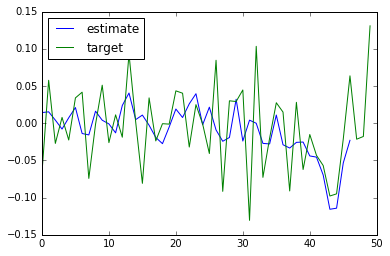

In [29]:
Results = Mom_ar13.results
y_hat = Results.loc[Results.TrialID == 0]['Estimates'].iloc[0]
y = Results.loc[Results.TrialID == 0]['Targets'].iloc[0]
plt.plot(np.array(y_hat[78:125]),label='estimate')
#plt.figure()
plt.plot(np.array(y[75:125]),label='target')
plt.legend(loc='upper left')

In [30]:
Mom_ar14 = Modelmaker(velocity_blocks)
Mom_ar14.setup_data(pred_size=-1, split_type='intra')
Results, output = Mom_ar14.apply_arima_models(trial_id=[0], pred_step=1, p=30,d=2,q=0,n_preds=200, dim='dalpha_2')


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.